In [95]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

In [96]:
SAMPLE_DATA_DIR = "/home/jovyan/sai-semocc1-workspace/practice/sereact/data/dl_challenge/95c679d3-9915-11ee-9103-bbb8eae05561"

In [97]:
def estimate_intrinsics(pc):
    H, W = pc.shape[1:]
    us, vs = np.meshgrid(np.arange(W), np.arange(H))  # (H, W)

    X = pc[0].flatten()
    Y = pc[1].flatten()
    Z = pc[2].flatten()
    u = us.flatten()
    v = vs.flatten()

    valid = Z > 0.01  # filter out invalid points
    X, Y, Z, u, v = X[valid], Y[valid], Z[valid], u[valid], v[valid]

    fx = np.median((u - W / 2) * Z / X)
    fy = np.median((v - H / 2) * Z / Y)
    cx = W / 2
    cy = H / 2

    K = np.array([[fx, 0, cx],
                  [0, fy, cy],
                  [0,  0,  1]])
    return K

In [98]:
def estimate_extrinsics(bbox3d, mask, pc, K):
    for i in range(len(bbox3d)):
        obj_mask = mask[i]
        ys, xs = np.where(obj_mask)
        if len(xs) < 50:
            continue

        object_points = []
        image_points = []

        for corner in bbox3d[i]:
            dists = np.linalg.norm(pc[:, ys, xs].transpose(1, 0) - corner, axis=1)
            min_idx = np.argmin(dists)
            x2d, y2d = xs[min_idx], ys[min_idx]
            image_points.append([x2d, y2d])
            object_points.append(corner)

        object_points = np.array(object_points).astype(np.float32)
        image_points = np.array(image_points).astype(np.float32)

        success, rvec, tvec, _ = cv.solvePnPRansac(object_points, image_points, K, None)
        if success:
            return rvec, tvec, i
    return None, None, -1

In [99]:
def draw_projected_bbox(rgb, bbox3d, rvec, tvec, K):
    img = rgb.copy()
    rvec_eye, tvec_eye = np.array([0.0, 0.0, 0.0]), np.array([0.0, 0.0, 0.0])
    points_2d, _ = cv.projectPoints(bbox3d, rvec_eye, tvec_eye, K, None)
    # points_2d, _ = cv.projectPoints(bbox3d, rvec, tvec, K, None)
    points_2d = points_2d.squeeze().astype(np.int32)

    # draw cube lines
    for i in range(4):
        cv.line(img, tuple(points_2d[i]), tuple(points_2d[(i+1)%4]), (0,255,0), 2)
        cv.line(img, tuple(points_2d[i+4]), tuple(points_2d[(i+1)%4 + 4]), (0,255,0), 2)
        cv.line(img, tuple(points_2d[i]), tuple(points_2d[i+4]), (0,255,0), 2)
    return img

In [100]:
def process_sample(sample_dir):
    pc = np.load(os.path.join(sample_dir, 'pc.npy'))
    bbox3d = np.load(os.path.join(sample_dir, 'bbox3d.npy'))
    mask = np.load(os.path.join(sample_dir, 'mask.npy'))
    rgb = np.array(Image.open(os.path.join(sample_dir, 'rgb.jpg')))

    K = estimate_intrinsics(pc)
    print(f"Intrinsic Matrix : {K}")
    rvec, tvec, box_idx = estimate_extrinsics(bbox3d, mask, pc, K)

    print(f"Extrinsics: \n rvec : {rvec} \n tvec : {tvec}")
    rot_mat, _ = cv.Rodrigues(rvec)
    print(f"Rotation Matrix : {rot_mat}")

    extrinsic_mat = np.eye(4,4)
    extrinsic_mat[:3,:3] = rot_mat
    extrinsic_mat[:3,-1] = tvec.ravel()
    print(f"Extrinsic Matrix : {extrinsic_mat}")

    if rvec is not None:
        vis_img = draw_projected_bbox(rgb, bbox3d[2], rvec, tvec, K)
        plt.figure(figsize=(10, 7))
        plt.imshow(vis_img)
        plt.title(f"Projected 3D BBox - Object #{box_idx}")
        plt.axis('off')
        plt.show()
    else:
        print("Could not estimate extrinsics for any object in sample.")

Intrinsic Matrix : [[886.4093777    0.         303.5       ]
 [  0.         882.15950187 240.5       ]
 [  0.           0.           1.        ]]
Extrinsics: 
 rvec : [[ 0.08897682]
 [-0.04387886]
 [ 0.01415356]] 
 tvec : [[0.03892053]
 [0.0891593 ]
 [0.01875566]]
Rotation Matrix : [[ 0.99893805 -0.01608035 -0.04317632]
 [ 0.01217941  0.9959448  -0.08913823]
 [ 0.0444346   0.08851771  0.995083  ]]
Extrinsic Matrix : [[ 0.99893805 -0.01608035 -0.04317632  0.03892053]
 [ 0.01217941  0.9959448  -0.08913823  0.0891593 ]
 [ 0.0444346   0.08851771  0.995083    0.01875566]
 [ 0.          0.          0.          1.        ]]


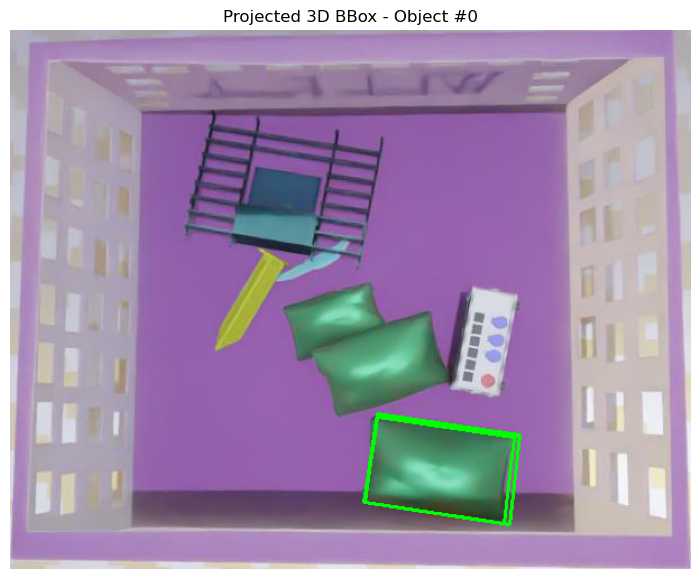

In [101]:
process_sample(SAMPLE_DATA_DIR)